# Regularization & Optimization


In [1]:
# @markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = ""  # @param {type:"string"}
my_pod = "Select"  # @param ["Factorial Ferrets", "Causal Crows", "Recursive Roosters", "Bayesian Bighorns", "Probabilistic Pronghorns", "Hashing Hares", "Multiplicative Mustangs", "Curiosity Capybaras", "Subspace Salamanders"]
my_email = ""  # @param {type:"string"}


In [2]:
# start timing
import time

try:
    t0
except NameError:
    t0 = time.time()


**Ensure you're running a GPU notebook.**

From "Runtime" in the drop-down menu above, click "Change runtime type". Ensure that "Hardware Accelerator" says "GPU".


In [3]:
# @title Import functions
from __future__ import print_function
import torch
import pathlib
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils.prune as prune
from torch.optim.lr_scheduler import StepLR
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from tqdm import tqdm
from IPython.display import HTML, display


Video available at https://youtube.com/watch?v=bc1nsP4htVg


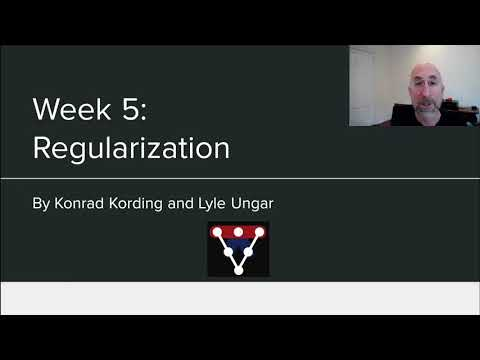

In [4]:
# @title Video: Introduction to Regularization
try:
    t1
except NameError:
    t1 = time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="bc1nsP4htVg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## Learning Objectives

1.  Regularization as shrinkage of overparameterized models
    1.  L1
    2.  L2
    3.  early stopping
2.  Regularization by Dropout
3.  Regularization by Data Augmentation
4.  Perils of Hyper-Parameter Tuning
5.  Rethinking generalization


## Section 1: Regularization is Shrinkage


Video available at https://youtube.com/watch?v=B4CsCKViB3k


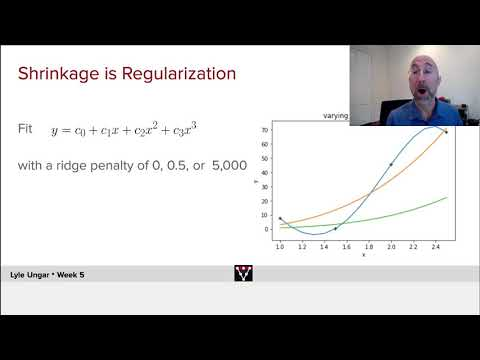

In [5]:
# @title Video : Introduction to Regularization
try:
    t2
except NameError:
    t2 = time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="B4CsCKViB3k", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


One way to think about Regularization is to think in terms of the magnitude of the overall weights of the model. A model with big weights can fit more data perfectly. Wheras a model with smaller weights tend to underperform on the train set but can suprisingly do very well on the test set. Too small of a weights can also be as issue as it can the underfit the model.

This week we use the sum of Frobenius Norm of all the tensors in the model as a metric to measure to measure the "size of the model".


### Exercise 1: Frobenius Norm

Before we start let us do a quick recollection of Frobenius Norm. The Frobenius norm, sometimes also called the Euclidean norm (a term unfortunately also used for the vector $L^2$ norm), is matrix norm of an m×n matrix A, defined as the square root of the sum of the absolute squares of its elements.

\begin{equation}
||A||_F= \sqrt{\sum_{i=1}^m\sum_{j=1}^n|a_{ij}|^2}
\end{equation}


In [6]:
def calculate_frobenius_norm(model: nn.Module) -> float:
    """
    Calculates the Frobenius norm of all the weights in a model

    Arguments:
        model: PyTorch model

    Returns:
        float: Frobenius norm of all weights in the model

    """
    # Hint: Check out nn.Module#named_parameters
    raise NotImplementedError("Implement this function!")


net = nn.Linear(10, 1)
print(f"Frobenius Norm of Single Linear Layer: {calculate_frobenius_norm(net)}")


Frobenius Norm of Single Linear Layer: 0.5934033241843465


## Section 2: Overfitting


Video available at https://youtube.com/watch?v=RlaGyRKP2nY


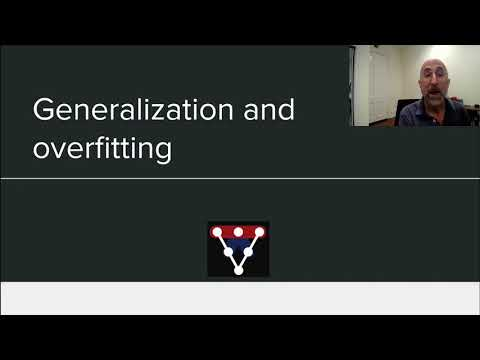

In [7]:
# @title Video : Overfitting
try:
    t3
except NameError:
    t3 = time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="RlaGyRKP2nY", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## Visualizing Overfitting

Let's create some synthetic dataset that we will use to illustrate overfitting in neural networks.


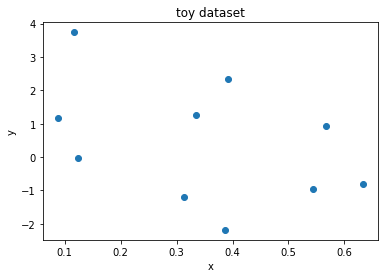

In [8]:
# creating train data
X = torch.rand((10, 1))
X.sort(dim=0)

# adding small error in the data
Y = 2 * X + 2 * torch.empty((X.shape[0], 1)).normal_(mean=0, std=1)

X = X.unsqueeze_(1)
Y = Y.unsqueeze_(1)

# visualizing trian data
plt.scatter(X.numpy(), Y.numpy())
plt.xlabel("x")
plt.ylabel("y")
plt.title("toy dataset")
plt.show()

# creating test dataset
X_test = torch.linspace(0, 1, 40)
X_test = X_test.reshape((40, 1, 1))


Let's create a NN that can fit on the dataset we just created and train it.


In [9]:
class Net(nn.Module):
    """
    A simple network with leaky relu activation
    """

    def __init__(self):
        """
        Initializes the network
        """
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 300)
        self.fc2 = nn.Linear(300, 500)
        self.fc3 = nn.Linear(500, 1)

    def forward(self, x):
        """
        Forward pass of the network
        """
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        output = self.fc3(x)
        return output


In [10]:
# train the network on toy dataset
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
max_epochs = 1000
iters = 0

running_predictions = np.empty((40, (int)(max_epochs / 500 + 1)))

train_loss = []
test_loss = []
model_norm = []

for epoch in tqdm(range(max_epochs)):

    # training
    model_norm.append(calculate_frobenius_norm(model))
    model.train()
    optimizer.zero_grad()
    predictions = model(X)
    loss = criterion(predictions, Y)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.data)
    model.eval()
    Y_test = model(X_test)
    loss = criterion(Y_test, 2 * X_test)
    test_loss.append(loss.data)

    if epoch % 500 == 0 or epoch == max_epochs - 1:
        running_predictions[:, iters] = Y_test[:, 0, 0].detach().numpy()
        iters += 1


100%|██████████| 1000/1000 [00:03<00:00, 312.62it/s]


Now that we have finished training, let's see how the model has evolved over the training process.


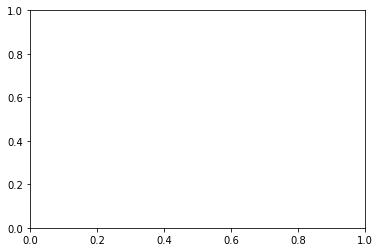

In [11]:
fig = plt.figure()
ax = plt.axes()


def frame(i):
    ax.clear()
    ax.scatter(X[:, 0, :].numpy(), Y[:, 0, :].numpy())
    plot = ax.plot(X_test[:, 0, :].detach().numpy(), running_predictions[:, i])
    title = "Epoch: " + str(i * 500)
    plt.title(title)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    return plot


anim = animation.FuncAnimation(
    fig, frame, frames=range(20), blit=False, repeat=False, repeat_delay=10000
)
anim


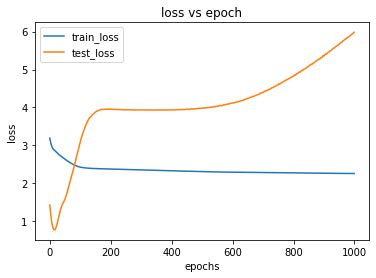

In [12]:
# @title Plot the train and test losses [Note: You may have to run this twice]
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("loss vs epoch")
plt.legend()
plt.show()


Now let's vizualize the frobenious norm of the model as we trained and you should see that the value of weights increased lineraly w.r.t epochs


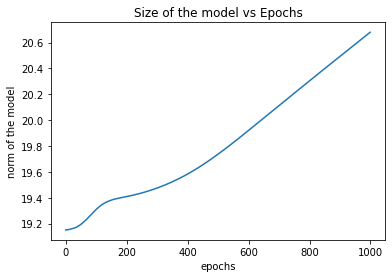

In [13]:
# @title Frobenious norm of the model
model_norm = [n.detach() if isinstance(n, torch.Tensor) else n for n in model_norm]
plt.plot(model_norm)
plt.ylabel("norm of the model")
plt.xlabel("epochs")
plt.title("Size of the model vs Epochs")
plt.show()


**Quiz Question 1:** What trend do you see w.r.t to train and test losses(where do you see the minimum of the losses)? What does it tell about the model we trained?


In [14]:
trend = ""  # @param {type:"string"}


### Overfitting on Test Dataset

In principle, we should not touch our test set until after we have chosen all our hyperparameters. Where we were to use the test data in the model selection process, there is a risk that we might overfit the test data. Then we would be in serious trouble. If we overfit our training data, there is always the evaluation on test data to keep us honest. But if we overfit the test data, how would we ever know?

Note that there is another kind of overfitting: you do "honest" fitting on one set of images or posts, or medical records, but it may not generalize to other sets of images, posts or medical records.


### Validation Dataset

A common practice to address this problem is to split our data three ways, using a validation dataset (or validation set) to tune the hyperparameters.

Ideally we would only touch the test data once, to assess the very best model or to compare a small number of models to each other, real-world test data is seldom discarded after just one use.


**Quiz Question 2:** Given that a NN fit/memorized the training data perfectly, do you think it generalizes well? What makes you think it does or doesn't?


In [15]:
memorize_or_generalize = '' #@param {type:"string"}

## Section 3: Early Stopping


Video available at https://youtube.com/watch?v=GA6J-50GCWs


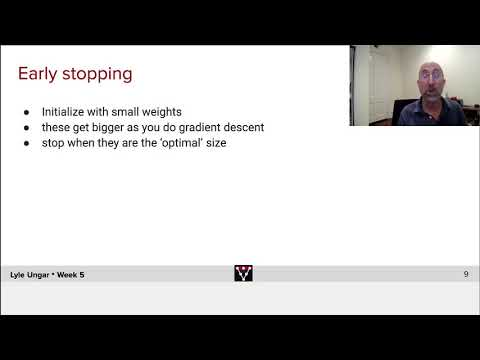

In [16]:
#@title Video : Early Stopping
try: t4;
except NameError: t4=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="GA6J-50GCWs", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Now that we have established that the validation accuracy reaches the peak well before the model overfits we want to stop the training early. You should have also observed from the above plots that the train/test loss on real data is not very smooth and hence you might guess that the choice of epoch can play a significant role with respect to the val/test accuracy of your model. 

Early stopping is a way to end training when the validation accuracies do not increase over a certain number of epochs. Though this makes sure that we don't overfit on the train data **it doesn't solve the problem of local variance, i.e. that the accuracy can be very volatile between epochs**. To overcome this, we also save the best model based on the val loss/accuracy for use on test dataset.

![Overfitting](https://images.deepai.org/glossary-terms/early-stopping-machine-learning-5422207.jpg)

**Quiz Question 3:** Do you think Early stopping can be harmful for the training of your network?

In [17]:
early_stopping = ""  # @param {type:"string"}


## Section 4: Dropout


Video available at https://youtube.com/watch?v=a4nX4T-3xsc


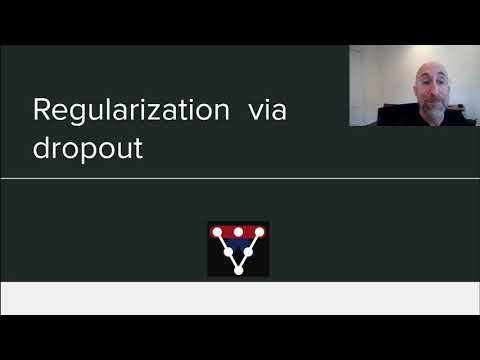

In [18]:
#@title Video : Dropout
try: t6;
except NameError: t6=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="a4nX4T-3xsc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Dropout involves injecting noise while computing each internal layer during forward propagation. The method is called dropout because we literally drop out some neurons during training. Throughout training, on each iteration, standard dropout consists of zeroing out some fraction of the nodes in each layer before calculating the subsequent layer.

![Dropout](https://d2l.ai/_images/dropout2.svg)


Now lets revisit the toy dataset that we generated above to visualize how the dropout stabilizes training on a noisy dataset

In [19]:
##Network Class - 2D
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(1, 300)
        self.fc2 = nn.Linear(300, 500)
        self.fc3 = nn.Linear(500, 1)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.leaky_relu(self.dropout1(self.fc1(x)))
        x = F.leaky_relu(self.dropout2(self.fc2(x)))
        output = self.fc3(x)
        return output

In [20]:
#train the network on toy dataset
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-4)
max_epochs = 10000
iters = 0

running_predictions_dp = np.empty((40,(int)(max_epochs/500)))

train_loss_dp = []
test_loss_dp = []
model_norm_dp = []

for epoch in tqdm(range(max_epochs)):

    #training
    model_norm_dp.append(calculate_frobenius_norm(model))
    model.train()
    optimizer.zero_grad()
    predictions = model(X)
    loss = criterion(predictions,Y)
    loss.backward()
    optimizer.step()

    train_loss_dp.append(loss.data)
    model.eval()
    Y_test = model(X_test)
    loss = criterion(Y_test,2*X_test)
    test_loss_dp.append(loss.data)

    if(epoch % 500 == 0 or epoch == max_epochs):
        running_predictions_dp[:,iters] = Y_test[:,0,0].detach().numpy()
        iters += 1

100%|██████████| 10000/10000 [00:36<00:00, 277.20it/s]


Now that we have finished training, let's see how the model has evolved over the training process.

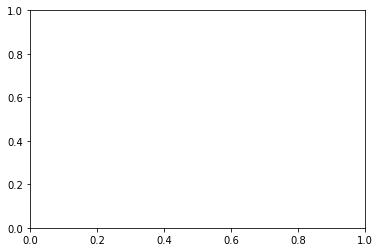

In [21]:
fig = plt.figure()
ax = plt.axes()
def frame(i):
    ax.clear()
    ax.scatter(X[:,0,:].numpy(),Y[:,0,:].numpy())
    plot = ax.plot(X_test[:,0,:].detach().numpy(),running_predictions_dp[:,i])
    title = "Epoch: " + str(i * 500)
    plt.title(title)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    return plot
anim = animation.FuncAnimation(fig, frame, frames=range(20), blit=False, repeat=False, repeat_delay=10000)
anim

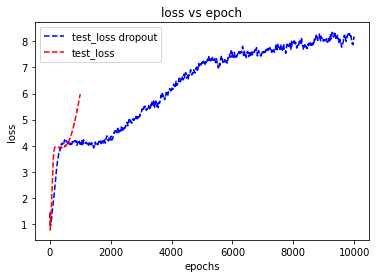

In [22]:
# @title Plot the train and test losses [You may have to run this twice]
plt.plot(test_loss_dp, label="test_loss dropout", c="blue", ls="dashed")
plt.plot(test_loss, label="test_loss", c="red", ls="dashed")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("loss vs epoch")
plt.legend()
plt.show()


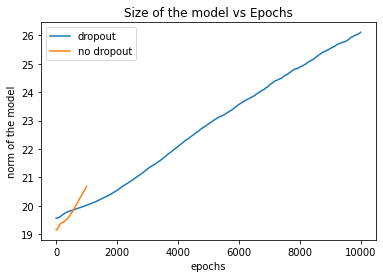

In [23]:
#@title Plot model weights with epoch
model_norm_dp = [n.detach() if isinstance(n, torch.Tensor) else n for n in model_norm_dp]
plt.plot(model_norm_dp,label = 'dropout')
plt.plot(model_norm,label = 'no dropout')
plt.ylabel('norm of the model')
plt.xlabel('epochs')
plt.legend()
plt.title('Size of the model vs Epochs')
plt.show()

### Dropout Implementation Caveats: 


*  Dropout is used only during training the model, during testing the complete model weights are used and hence it is important to use model.eval() before testing the model. 

* Dropout reduces the capacity of the model during training and hence as a general practice wider networks are used when using dropout. If you are using a dropout with a random probability of 0.5 then you might want to double the number of hidden neurons in that layer.

**Quiz Question 8:** Can you think of more ways of augmenting training data?

In [ ]:
data_augment = '' #@param {type:"string"}

---
# Wrap up

## Submit responses

In [ ]:
# @markdown #Run Cell to Show Airtable Form
# @markdown ##**Confirm your answers and then click "Submit"**

import time
import numpy as np
import urllib.parse
from IPython.display import IFrame


def prefill_form(src, fields: dict):
    """
    src: the original src url to embed the form
    fields: a dictionary of field:value pairs,
    e.g. {"pennkey": my_pennkey, "location": my_location}
    """
    # prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
    # src = src + prefills
    # src = "+".join(src.split(" "))
    # return src

    prefill_fields = {}
    for key in fields:
        new_key = "prefill_" + key
        prefill_fields[new_key] = fields[key]
    prefills = urllib.parse.urlencode(prefill_fields)
    src = src + prefills
    return src


# autofill time if it is not present
try:
    t0
except NameError:
    t0 = time.time()
try:
    t1
except NameError:
    t1 = time.time()

# autofill fields if they are not present
# a missing pennkey and pod will result in an Airtable warning
# which is easily fixed user-side.
try:
    my_pennkey
except NameError:
    my_pennkey = ""
try:
    my_pod
except NameError:
    my_pod = "Select"
try:
    my_email
except NameError:
    my_email = ""

try:
    trend
except NameError:
    trend = ""
try:
    memorize_or_generalize
except NameError:
    memorize_or_generalize = ""
try:
    early_stopping
except NameError:
    early_stopping = ""


variation = ""
lambda_1 = ""
lambda_2 = ""
elastic_net = ""
try:
    data_augment
except NameError:
    data_augment = ""

times = [(t - t0) for t in [t1]]

fields = {
    "pennkey": my_pennkey,
    "my_pod": my_pod,
    "email": my_email,
    "trend": trend,
    "memorize_or_generalize": memorize_or_generalize,
    "early_stopping": early_stopping,
    "variation": variation,
    "lambda_1": lambda_1,
    "lambda_2": lambda_2,
    "elastic_net": elastic_net,
    "data_augment": data_augment,
    "cumulative_times": times,
}

src = "https://airtable.com/embed/shrXrrMFkvePCRHoJ?"

# now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src=prefill_form(src, fields), width=800, height=400))
